<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/w2d1_updates/tutorials/W2D1_ConvnetsAndRecurrentNeuralNetworks/W2D1_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 2: Training loop of CNNs
**Week 2, Day 1: Week 2, Day 1: Convnets And Recurrent Neural Networks**

**By Neuromatch Academy**

__Content creators:__ Alona Fyshe, Dawn McKnight, Richard Gerum, Cassidy Pirlot, Rohan Saha, Liam Peet-Pare, Saeed Najafi 

__Content reviewers:__ Saeed Salehi, Lily Cheng, Yu-Fang Yang, Polina Turishcheva, Bettina Hein

__Content editors:__ Nina Kudryashova, Anmol Gupta, Spiros Chavlis

__Production editors:__ Alex Tran-Van-Minh, Spiros Chavlis

*Based on material from:* Konrad Kording, Hmrishav Bandyopadhyay, Rahul Shekhar, Tejas Srivastava

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial Objectives
At the end of this tutorial, we will be able to:
- Understand pooling
- Code a simple Convolutional Neural Nework (CNN) in pytorch

 

In [1]:
# @title Tutorial slides

# @markdown These are the slides for the videos in this tutorial
from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/mkgqs/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

---
# Setup

In [2]:
# @title Install dependencies
!pip install livelossplot --quiet
!pip install opencv-python --quiet

In [3]:
# Imports
import os
import cv2
from PIL import Image
from tqdm.auto import tqdm

import time
import torch
import pathlib
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
from IPython.display import HTML, display

from tqdm.notebook import tqdm, trange
from time import sleep

In [4]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

plt.rcParams["mpl_toolkits.legacy_colorbar"] = False

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

In [5]:
# @title Helper functions

# just returns accuracy on test data
def test(model, device, data_loader):
  model.eval()
  correct = 0
  total = 0
  for data in data_loader:
    inputs, labels = data
    inputs = inputs.to(device).float()
    labels = labels.to(device).long()

    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  return f"{acc}%"

In [6]:
# @title Plotting functions

# code to plot loss and accuracy
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)
  #plt.show()

In [7]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [8]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [9]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


---
# Section 1: Training a CNN

In the last section we coded up a CNN, but trained it with some predefined functions.  In this section, we will walk through an example of training loop for a convolution net. In this section, we will train a CNN using convolution layers and maxpool and then observe what the training and validation curves look like. In Section 6, we will add regularization and data augmentation to see what effects they have on the curves and why it is important to incorporate them while training our network.
<br>


In [10]:
# @title Video 1: Writing your own training loop
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1Ko4y1Q7UG", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"L0XG-QKv5_w", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Section 1.1: Understand the Dataset

The dataset we are going to use for this task is called Fashion-MNIST. It consists of a training set of 60,000 examples and a test set of 10,000 examples. We further divide the test set into a validation set and a test set (8000 and 2000 resp). Each example is a 28*28 gray scale image, associated with a label from 10 classes. Following are the labels of the dataset:

0 T-shirt/top <br>
1 Trouser <br>
2 Pullover <br>
3 Dress <br>
4 Coat <br> 
5 Sandal <br>
6 Shirt <br> 
7 Sneaker <br> 
8 Bag <br> 
9 Ankle boot <br> 

**NOTE:** we will reduce the dataset to just the two categories T-shirt/top and Shirt to reduce the training time from about 10min to 2min. We later provide pretrained results to give you an idea how the results would look on the whole dataset.

In [11]:
# @markdown Getting Fashion-Mnist Data

def get_fashion_mnist_dataset(seed):
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.1307,), (0.3081,))
      ])

  train_data = datasets.FashionMNIST(root='./data', download=True,
                                      train=True, transform=transform)

  test_data = datasets.FashionMNIST(root='./data',  download=True,
                                    train=False, transform=transform)
  set_seed(seed)
  validation_data, test_data = torch.utils.data.random_split(test_data,
                                                              [int(0.8*len(test_data)),
                                                              int(0.2*len(test_data))])

  return train_data, validation_data, test_data

num_classes = 10
train_data, validation_data, test_data = get_fashion_mnist_dataset(seed=SEED)

Random seed 2021 has been set.


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [12]:
# @markdown Reducing Fashion-Mnist Data (to two categories)

# @markdown *NOTE: if you want to train on the whole dataset, just run the cell above
# @markdown and do not execute this cell.*
# need to split into train, validation, test
def reduce_classes(data):
  # only want T-Shirts (0) and Shirts (6) labels
  train_idx = (data.targets == 0) | (data.targets == 6)
  data.targets = data.targets[train_idx]
  data.data = data.data[train_idx]

  # convert Xs predictions to 1, Os predictions to 0
  data.targets[data.targets == 6] = 1

  return data


def get_fashion_mnist_dataset(seed):
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.1307,), (0.3081,))
      ])

  train_data = datasets.FashionMNIST(root='./data', download=True,
                                     train=True, transform=transform)
  train_data = reduce_classes(train_data)

  test_data = datasets.FashionMNIST(root='./data',  download=True,
                                    train=False, transform=transform)
  test_data = reduce_classes(test_data)

  set_seed(seed)
  validation_data, test_data = torch.utils.data.random_split(test_data,
                                                             [int(0.8*len(test_data)),
                                                              int(0.2*len(test_data))])

  return train_data, validation_data, test_data


num_classes = 2
train_data, validation_data, test_data = get_fashion_mnist_dataset(seed=SEED)

Random seed 2021 has been set.


Here's some code to visualize the dataset.

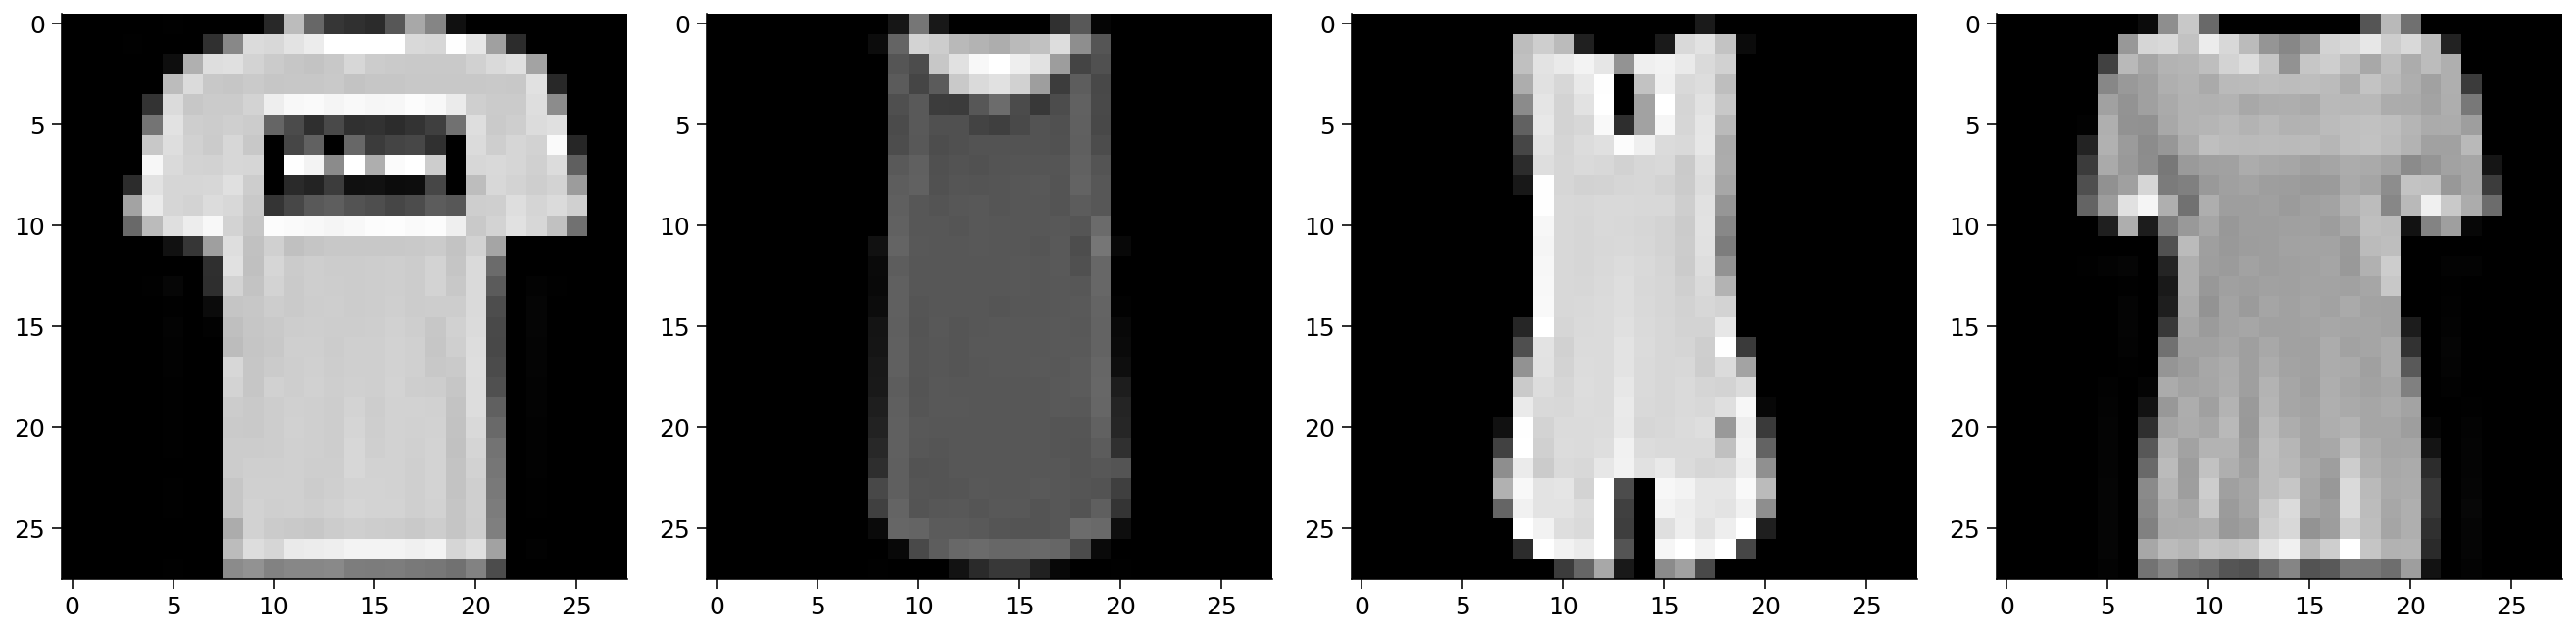

In [13]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.imshow(train_data[0][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax2.imshow(train_data[1][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax3.imshow(train_data[2][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax4.imshow(train_data[3][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
fig.set_size_inches(18.5, 10.5)
plt.show()

Take a minute with your pod and talk about which classes you think would be most confusable.  How hard will it be to differentiate t-shirt/tops from shirts?

In [14]:
# @title Video 2: The Training Loop
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1av411n7VJ", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"ZgYYgktqaP8", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Section 1.2: Backpropagation Reminder

_Feel free to skip if you've got a good handle on Backpropagation_

We know that we multiply the input data/tensors with weight matrices to obtain some output. Initially, we don't know what the actual weight matrices are so we initialize them with some random values. These random weight matrices when applied as a transformation on the input gives us some output. At first the outputs/predictions will match the true labels only by chance. 

To improve performance, we need to change the weight matrices so that the predicted outputs are similar to the true outputs (labels). We first calculate how far away the predicted outputs are to the true outputs using a loss function. Based on the loss function, we change the values of our weight matrices using the gradients of the error with respect to the weight matrices. 

Since we are using PyTorch throughout the course, we will use the built-in functions to update the weights. We call the `backward()` method on our 'loss' variable to calculate the gradients/derivatives with respect to all the weight matrices and biases. And then we call the `step()` method on the optimizer variable to apply the gradient updates to our weight matrices.

Here's an animation of backpropagation works.


<figure>
    <center><img src=https://machinelearningknowledge.ai/wp-content/uploads/2019/10/Backpropagation.gif>
    <figcaption> Stride Two </figcaption>
    </center>    
</figure>

[This](https://machinelearningknowledge.ai/animated-explanation-of-feed-forward-neural-network-architecture/) article has more animations.



Let's first see a sample training loop. First, we create the network and load a dataset. Then we look at the training loop.

In [15]:
# Create a sample network
class emnist_net(nn.Module):
  def __init__(self):
    super().__init__()
    # First define the layers.
    self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
    self.fc1 = nn.Linear(7*7*64, 256)
    self.fc2 = nn.Linear(256, 26)

  def forward(self, x):
    # Conv layer 1.
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 2.
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Fully connected layer 1.
    x = x.view(-1, 7*7*64)  # You have to first flatten the ourput from the
                            # previous convolution layer.
    x = self.fc1(x)
    x = F.relu(x)

    # Fully connected layer 2.
    x = self.fc2(x)
    # x = F.softmax(x)

    return x

In [16]:
# @markdown ### Load a sample dataset
# Load the data
mnist_train = datasets.EMNIST(root="./datasets", train=True,
                              transform=transforms.ToTensor(),
                              download=True, split='letters')
mnist_test = datasets.EMNIST(root="./datasets", train=False,
                             transform=transforms.ToTensor(),
                             download=True, split='letters')

# labels should start from 0
mnist_train.targets -= 1
mnist_test.targets -= 1

# create data loaders
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100,
                                           shuffle=False,
                                           worker_init_fn=seed_worker,
                                           generator=g_seed)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100,
                                          shuffle=False,
                                          worker_init_fn=seed_worker,
                                          generator=g_seed)

In [17]:
# Training
# Instantiate model
# Puts the Model on the GPU (Select runtime-type as GPU
#                            from the 'Runtime->Change Runtime type' option).
model = emnist_net().to(DEVICE)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # <---- change here

# Iterate through train set minibatchs
for epoch in trange(3):  # <---- change here
  for images, labels in tqdm(train_loader):

    # Zero out the gradients
    optimizer.zero_grad() # Fill this out.

    # Forward pass
    x = images
    # Move the data to GPU for faster execution.
    x, labs = x.to(DEVICE), labels.to(DEVICE)
    y = model(x)

    # Calculate loss.
    loss = criterion(y, labs)

    # Backpropagation and gradient update.
    loss.backward() # Calculate gradients.
    optimizer.step() # Apply gradient udpate.


## Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
  # Iterate through test set minibatchs
  for images, labels in tqdm(test_loader):
    # Forward pass
    x = images
      # Move the data to GPU for faster execution.
    x, labs = x.to(DEVICE), labels.to(DEVICE)
    y = model(x)

    predictions = torch.argmax(y, dim=1)
    correct += torch.sum((predictions == labs).float())

print('Test accuracy: {}'.format(correct/total))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Test accuracy: 0.931538462638855


You already coded the structure of a CNN. Now, you are going to implement the training loop for a CNN. 
- Choose the correct criterion 
- Code up the training part (calculating gradients, loss, stepping forward)
- Keep a track of the running loss i.e for each epoch we want to to know the average loss of the batch size. We have already done the same for accuracy for you. 



## Section 1.3: Fashion-MNIST dataset
Now Let us train on the actual Fashion-MNIST dataset.

In [18]:
# @markdown #### Getting the DataLoaders (Run Me)
def get_data_loaders(train_dataset, validation_dataset, test_dataset, seed,
                     batch_size=64):

  g_seed = torch.Generator()
  g_seed.manual_seed(seed)

  train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=0,
                            worker_init_fn=seed_worker,
                            generator=g_seed)
  validation_loader = DataLoader(validation_dataset,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 num_workers=0,
                                 worker_init_fn=seed_worker,
                                 generator=g_seed)
  test_loader = DataLoader(test_dataset,
                           batch_size=batch_size,
                           shuffle=True,
                           num_workers=0,
                           worker_init_fn=seed_worker,
                           generator=g_seed)

  return train_loader, validation_loader, test_loader


train_loader, validation_loader, test_loader = get_data_loaders(train_data,
                                                                validation_data,
                                                                test_data, SEED)

In [19]:
# This cell contains the code for the CNN we will be using in this section.
class FMNIST_Net1(nn.Module):
  def __init__(self):
    super(FMNIST_Net1, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)

    return x

## Coding Exercise 1: Code the training loop

Now try coding the training loop.

You should first have a `criterion` defined (you can use `CrossEntropyLoss` here, which you learned about last week) so that you can calculate the loss. Next, you should to put everything together. Start the training process by first obtaining the model output, calculating the loss, and finally updating the weights.

*Don't forget to zero out the gradients.*

NOTE: The comments in the `train` function provides many hints that will help you fill in the missing code. This will give you a solid understanding of the different steps involved in the training loop. 

In [20]:
def train(model, device, train_loader, validation_loader, epochs):

  criterion =  nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01, momentum=0.9)
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []
  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      # keeps track of the running loss
      running_loss = 0.
      correct, total = 0, 0
      for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        raise NotImplementedError("Update the steps of the train loop")
        ####################################################################
        # COMPLETE CODE FOR TRAINING LOOP by following these steps
        # 1. Get the model output (call the model with the data from this batch)
        output = ...

        # 2. Zero the gradients out (i.e. reset the gradient that the optimizer
        #                       has collected so far with optimizer.zero_grad())
        ...

        # 3. Get the Loss (call the loss criterion with the model's output
        #                  and the target values)
        loss = ...

        # 4. Calculate the gradients (do the pass backwards from the loss
        #                             with loss.backward())
        ...

        # 5. Update the weights (using the training step of the optimizer,
        #                        optimizer.step())
        ...

        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        raise NotImplementedError("Update the set_postfix function")
        ####################################################################
        # set loss to whatever you end up naming your variable when
        # calling criterion
        # for example, loss = criterion(output, target)
        # then set loss = loss.item() in the set_postfix function
        tepochs.set_postfix(loss=...)
        running_loss += ...  # add the loss for this batch

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      ####################################################################
      # Fill in missing code below (...),
      # then remove or comment the line below to test your function
      raise NotImplementedError("Append the train_loss")
      ####################################################################
      train_loss.append(...)  # append the loss for this epoch (running loss divided by the number of batches e.g. len(train_loader))
      train_acc.append(correct/total)

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0
      for data, target in validation_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()
        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      validation_loss.append(running_loss/len(validation_loader))
      validation_acc.append(correct/total)

  return train_loss, train_acc, validation_loss, validation_acc


set_seed(SEED)
## Uncomment to test your training loop
# net = FMNIST_Net1().to(DEVICE)
# train_loss, train_acc, validation_loss, validation_acc = train(net, DEVICE, train_loader, validation_loader, 20)
# plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

Random seed 2021 has been set.


Random seed 2021 has been set.


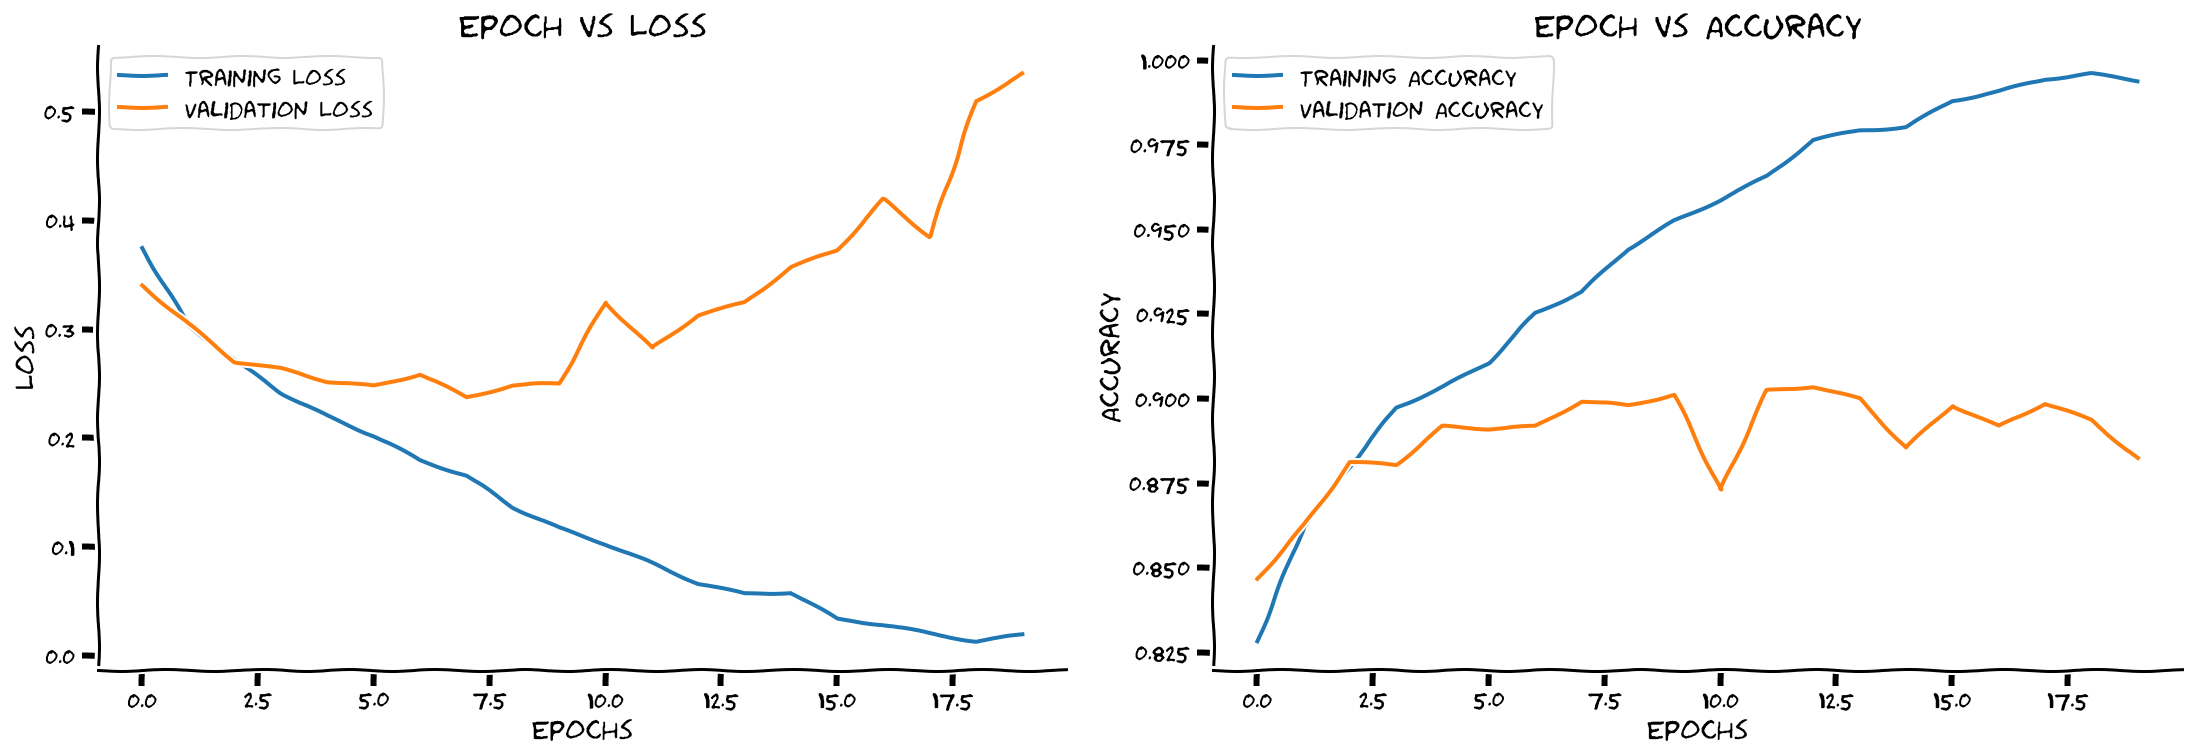

In [21]:
# to_remove solution
def train(model, device, train_loader, validation_loader, epochs):

  criterion =  nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01, momentum=0.9)
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []
  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      # keeps track of the running loss
      running_loss = 0.
      correct, total = 0, 0
      for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        # COMPLETE CODE FOR TRAINING LOOP by following these steps
        # 1. Get the model output (call the model with the data from this batch)
        output = model(data)

        # 2. Zero the gradients out (i.e. reset the gradient that the optimizer
        #                       has collected so far with optimizer.zero_grad())
        optimizer.zero_grad()

        # 3. Get the Loss (call the loss criterion with the model's output
        #                  and the target values)
        loss = criterion(output, target)

        # 4. Calculate the gradients (do the pass backwards from the loss
        #                             with loss.backward())
        loss.backward()

        # 5. Update the weights (using the training step of the optimizer,
        #                        optimizer.step())
        optimizer.step()

        # set loss to whatever you end up naming your variable when
        # calling criterion
        # for example, loss = criterion(output, target)
        # then set loss = loss.item() in the set_postfix function
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()  # add the loss for this batch

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      train_loss.append(running_loss/len(train_loader))  # append the loss for this epoch (running loss divided by the number of batches e.g. len(train_loader))
      train_acc.append(correct/total)

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0
      for data, target in validation_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()
        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      validation_loss.append(running_loss/len(validation_loader))
      validation_acc.append(correct/total)

  return train_loss, train_acc, validation_loss, validation_acc


set_seed(SEED)
## Uncomment to test your training loop
net = FMNIST_Net1().to(DEVICE)
train_loss, train_acc, validation_loss, validation_acc = train(net, DEVICE, train_loader, validation_loader, 20)
with plt.xkcd():
  plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

The next cell contains the code for the CNN we will be using in this section.

Run the next cell to get the accuracy on the data!

In [22]:
test(net, DEVICE, test_loader)

'88.5%'

## Think! 1: Overfitting
Do you think this network is overfitting?
If yes, what can you do to combat this?

**Hint**: overfitting occurs when the training accuracy greatly exceeds the validation accuracy


In [23]:
# to_remove explanation

"""
The network is overfitting as the validation loss does not decrease further even
though the training loss still decreases. The validation loss even increases,
showing that further training is detrimental for the generalisation performance
of the network, hence it is overfitting.

To prevent overfitting, e.g. dropout can be used, as discussed in the next
section.
"""

'\nThe network is overfitting as the validation loss does not decrease further even\nthough the training loss still decreases. The validation loss even increases,\nshowing that further training is detrimental for the generalisation performance\nof the network, hence it is overfitting.\n\nTo prevent overfitting, e.g. dropout can be used, as discussed in the next\nsection.\n'

---
# Section 2: Overfitting - symptoms and cures

 

So you spent some time last week learning about regularization techniques. Below is a copy of the CNN model we used previously.  Now we want you to add some dropout regularization, and check if that helps reduce overfitting. If you're up for a challenge, you can try methods other than dropout as well.

## Coding Exercise 2.1: Adding Regularization

Add various regularization methods, feel free to add any and play around!

In [24]:
class FMNIST_Net2(nn.Module):
  def __init__(self):
    super(FMNIST_Net2, self).__init__()
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Add regularization layers")
    ####################################################################
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = ...
    self.dropout2 = ...
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x):
    ####################################################################
    # Now add the layers in your forward pass in appropriate order
    # then remove or comment the line below to test your function
    raise NotImplementedError("Add regularization in the forward pass")
    ####################################################################
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = ...
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = ...
    x = self.fc2(x)

    return x


set_seed(SEED)
## Uncomment below to check your code
# net2 = FMNIST_Net2().to(DEVICE)
# train_loss, train_acc, validation_loss, validation_acc = train(net2, DEVICE, train_loader, validation_loader, 20)
# plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

Random seed 2021 has been set.


Random seed 2021 has been set.


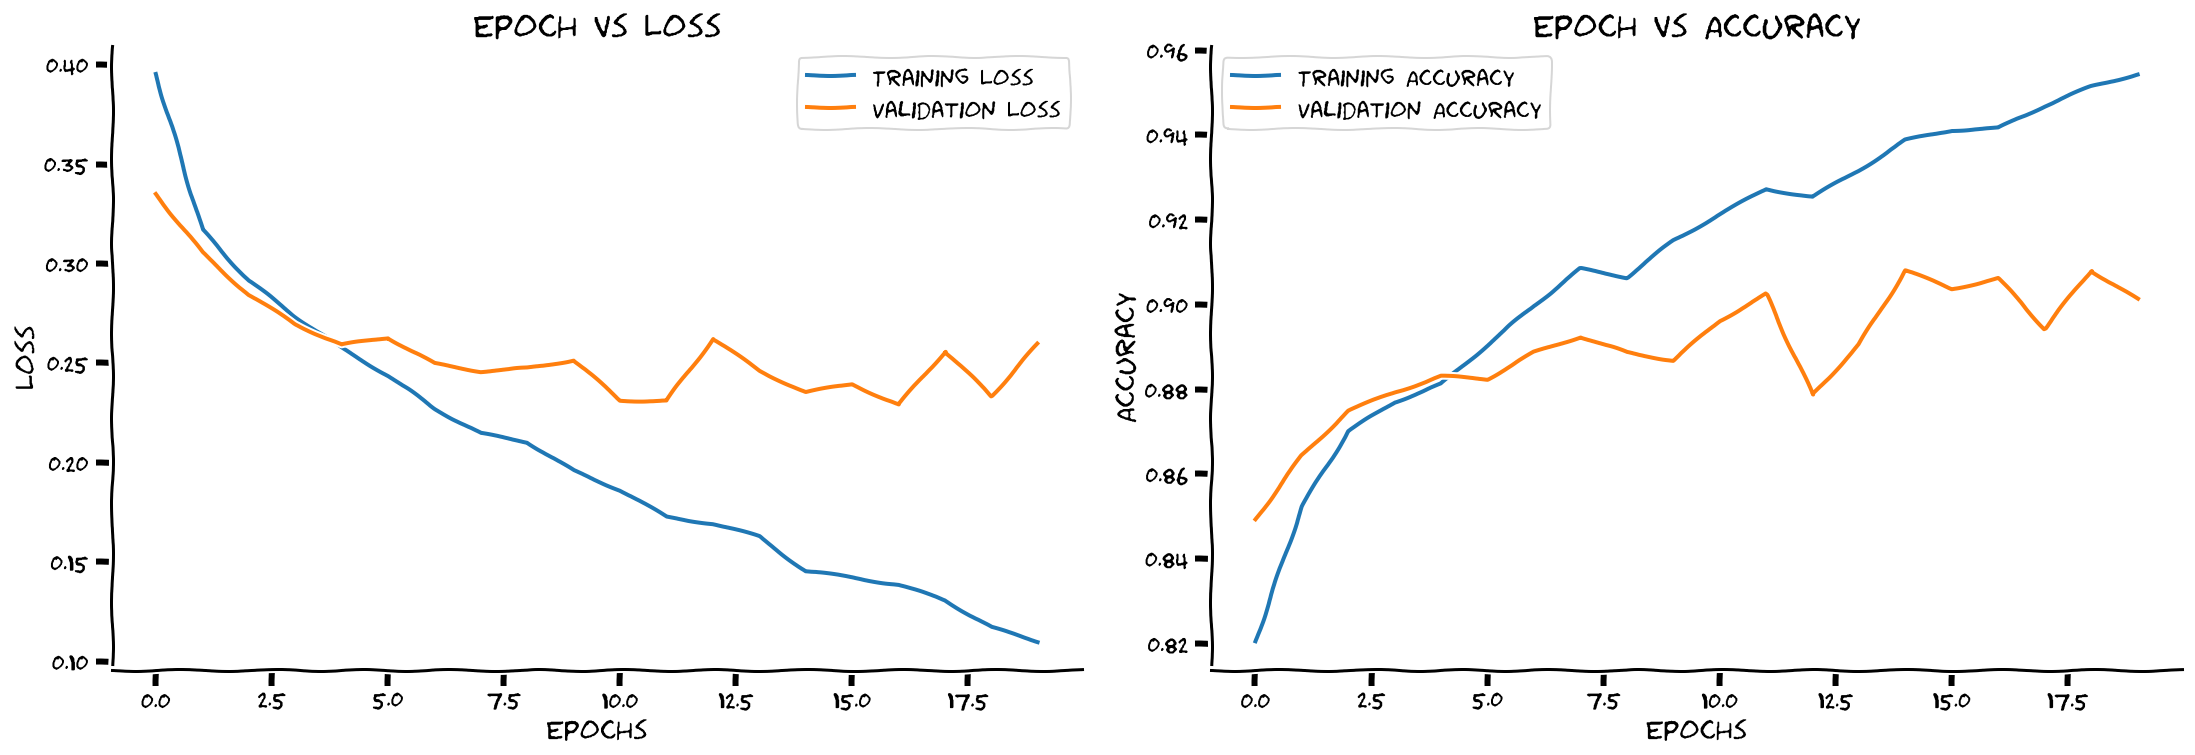

In [25]:
# to_remove solution
class FMNIST_Net2(nn.Module):
  def __init__(self):
    super(FMNIST_Net2, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout(0.5)
    self.dropout2 = nn.Dropout(0.25)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x


set_seed(SEED)
## Uncomment below to check your code
net2 = FMNIST_Net2().to(DEVICE)
train_loss, train_acc, validation_loss, validation_acc = train(net2, DEVICE, train_loader, validation_loader, 20)
with plt.xkcd():
  plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

Run the next cell to get the accuracy on the data!

In [26]:
test(net2, DEVICE, test_loader)

'87.5%'

## Think! 2.1: Regularization 

1. Is the training accuracy slightly reduced from before adding regularization? What accuracy were you able to reduce it to?

2. Why does the validation accuracy start higher than training accuracy?


In [27]:
# to_remove explanation

"""
1. The overfitting is now reduced, as the validation loss now does not increase
   strongly anymore. But as the training loss still decreases while the
   validation loss stays constant, the network is still overfitting, but this
   time it at least does not affect the generalisation performance as strongly
   as before.

2. Since dropout is only applied to training process, the training accuracy is
   reduced but not the validation accuracy.
""";

## Interactive Demo 2: Dropout exploration

If you want to try out more dropout parameter combinations, but do not have the time to run them, we have here precalculated some combinations you can use the sliders to explore them.

In [28]:
# @markdown  *Run this cell to enable the widget*

from ipywidgets import interactive, widgets, interactive_output

data = [[0, 0, [0.3495898238046372, 0.2901147632522786, 0.2504794800931469, 0.23571575765914105, 0.21297093365896255, 0.19087818914905508, 0.186408187797729, 0.19487689035211472, 0.16774938120803934, 0.1548648244958926, 0.1390149021382503, 0.10919439224922593, 0.10054351237820501, 0.09900783193594914, 0.08370604479507088, 0.07831853718318521, 0.06859792241866285, 0.06152600247383197, 0.046342475851873885, 0.055123823092992796], [0.83475, 0.8659166666666667, 0.8874166666666666, 0.8913333333333333, 0.8998333333333334, 0.9140833333333334, 0.9178333333333333, 0.9138333333333334, 0.9251666666666667, 0.92975, 0.939, 0.9525833333333333, 0.9548333333333333, 0.9585833333333333, 0.9655833333333333, 0.9661666666666666, 0.9704166666666667, 0.9743333333333334, 0.9808333333333333, 0.9775], [0.334623601436615, 0.2977438402175903, 0.2655304968357086, 0.25506321132183074, 0.2588835284113884, 0.2336345863342285, 0.3029863876104355, 0.240766831189394, 0.2719801160693169, 0.25231350839138034, 0.2500132185220718, 0.26699506521224975, 0.2934862145781517, 0.361227530837059, 0.33196919202804565, 0.36985905408859254, 0.4042587959766388, 0.3716402840614319, 0.3707024946808815, 0.4652537405490875], [0.866875, 0.851875, 0.8775, 0.889375, 0.881875, 0.900625, 0.85, 0.898125, 0.885625, 0.876875, 0.899375, 0.90625, 0.89875, 0.87, 0.898125, 0.884375, 0.874375, 0.89375, 0.903125, 0.890625]], [0, 0.25, [0.35404509995528993, 0.30616586227366266, 0.2872369573946963, 0.27564131199045383, 0.25969504263806853, 0.24728168408445855, 0.23505379509260046, 0.21552803914280647, 0.209761732277718, 0.19977611067526518, 0.19632092922767427, 0.18672360206379535, 0.16564940239124476, 0.1654047035671612, 0.1684555298985636, 0.1627526102349796, 0.13878319327263755, 0.12881529055773577, 0.12628930977525862, 0.11346105090837846], [0.8324166666666667, 0.8604166666666667, 0.8680833333333333, 0.8728333333333333, 0.8829166666666667, 0.88625, 0.89425, 0.90125, 0.9015833333333333, 0.90925, 0.9114166666666667, 0.917, 0.9268333333333333, 0.92475, 0.921, 0.9255833333333333, 0.9385, 0.9428333333333333, 0.9424166666666667, 0.9484166666666667], [0.3533937376737595, 0.29569859683513644, 0.27531551957130435, 0.2576177391409874, 0.26947550356388095, 0.25361743807792664, 0.2527468180656433, 0.24179009914398195, 0.28664454460144045, 0.23347773611545564, 0.24672816634178163, 0.27822364538908007, 0.2380720081925392, 0.24426509588956832, 0.2443918392062187, 0.24207917481660843, 0.2519641682505608, 0.3075403380393982, 0.2798181238770485, 0.26709021866321564], [0.826875, 0.87, 0.870625, 0.8875, 0.883125, 0.88625, 0.891875, 0.891875, 0.890625, 0.903125, 0.89375, 0.885625, 0.903125, 0.888125, 0.899375, 0.898125, 0.905, 0.905625, 0.898125, 0.901875]], [0, 0.5, [0.39775496332886373, 0.33771887778284704, 0.321900939132939, 0.3079229625774191, 0.304149763301966, 0.28249239723416086, 0.2861261191044716, 0.27356165798103554, 0.2654648520686525, 0.2697350280557541, 0.25354846321204877, 0.24612889034633942, 0.23482802549892284, 0.2389904112416379, 0.23742155821875055, 0.232423192127905, 0.22337309338469455, 0.2141852991932884, 0.20677659985549907, 0.19355326712607068], [0.8155, 0.83625, 0.8481666666666666, 0.8530833333333333, 0.8571666666666666, 0.86775, 0.8623333333333333, 0.8711666666666666, 0.8748333333333334, 0.8685833333333334, 0.8785, 0.8804166666666666, 0.8835833333333334, 0.8840833333333333, 0.88875, 0.8919166666666667, 0.8946666666666667, 0.8960833333333333, 0.906, 0.9063333333333333], [0.3430288594961166, 0.4062050700187683, 0.29745822548866274, 0.27728439271450045, 0.28092808067798614, 0.2577864158153534, 0.2651400637626648, 0.25632822573184966, 0.3082498562335968, 0.2812121778726578, 0.26345942318439486, 0.2577408078312874, 0.25757989794015884, 0.26434457510709763, 0.24917411386966706, 0.27261342853307724, 0.2445397639274597, 0.26001051396131514, 0.24147838801145555, 0.2471102523803711], [0.82875, 0.795625, 0.87, 0.87375, 0.865625, 0.8825, 0.8825, 0.87625, 0.848125, 0.87875, 0.8675, 0.889375, 0.8925, 0.866875, 0.87375, 0.87125, 0.895625, 0.90375, 0.90125, 0.88625]], [0, 0.75, [0.4454924576777093, 0.43416607585993217, 0.42200265769311723, 0.40520024616667566, 0.41137005166804536, 0.404100904280835, 0.40118067664034823, 0.40139733080534223, 0.3797615355158106, 0.3596332479030528, 0.3600061919460905, 0.3554147962242999, 0.34480382890460337, 0.3329520877054397, 0.33164913056695716, 0.31860941466181836, 0.30702565340919696, 0.30605297186907304, 0.2953788426486736, 0.2877389984403519], [0.7788333333333334, 0.7825, 0.7854166666666667, 0.7916666666666666, 0.7885, 0.7833333333333333, 0.7923333333333333, 0.79525, 0.805, 0.81475, 0.8161666666666667, 0.8188333333333333, 0.817, 0.8266666666666667, 0.82225, 0.8360833333333333, 0.8456666666666667, 0.8430833333333333, 0.8491666666666666, 0.8486666666666667], [0.3507828885316849, 0.3337512403726578, 0.34320746660232543, 0.3476085543632507, 0.3326113569736481, 0.33033264458179473, 0.32014619171619413, 0.3182142299413681, 0.30076164126396177, 0.3263852882385254, 0.27597591280937195, 0.29062016785144806, 0.2765174686908722, 0.269492534995079, 0.2679423809051514, 0.2691828978061676, 0.2726386785507202, 0.2541181230545044, 0.2580208206176758, 0.26315389811992645], [0.839375, 0.843125, 0.823125, 0.821875, 0.81875, 0.819375, 0.8225, 0.826875, 0.835625, 0.865, 0.868125, 0.855625, 0.868125, 0.884375, 0.883125, 0.875, 0.87375, 0.883125, 0.8975, 0.885]], [0.25, 0, [0.34561181647029326, 0.2834314257699124, 0.2583787844298368, 0.23892096465730922, 0.23207981773513428, 0.20245029634617745, 0.183908417583146, 0.17489413774393975, 0.17696723581707857, 0.15615438255778652, 0.14469048382833283, 0.12424647461305907, 0.11314761043189371, 0.11249036608422373, 0.10725672634199579, 0.09081190969160896, 0.0942245383271353, 0.08525650047677312, 0.06622548752583246, 0.06039895973307021], [0.8356666666666667, 0.8675833333333334, 0.88175, 0.8933333333333333, 0.8975833333333333, 0.91175, 0.91825, 0.9249166666666667, 0.9238333333333333, 0.9305, 0.938, 0.9465833333333333, 0.9525833333333333, 0.9539166666666666, 0.9555, 0.9615, 0.9606666666666667, 0.96275, 0.9725, 0.9764166666666667], [0.31630186855792997, 0.2702121251821518, 0.2915778249502182, 0.26050266206264494, 0.27837209939956664, 0.24276352763175965, 0.3567117482423782, 0.2752074319124222, 0.2423130339384079, 0.2565067422389984, 0.28710135877132414, 0.266545415520668, 0.31818037331104276, 0.28757534325122835, 0.2777567034959793, 0.2998969575762749, 0.3292293107509613, 0.30775387287139894, 0.32681577146053314, 0.44882203072309496], [0.85375, 0.879375, 0.875625, 0.89, 0.86125, 0.884375, 0.851875, 0.8875, 0.89625, 0.875625, 0.8675, 0.895, 0.888125, 0.89125, 0.889375, 0.880625, 0.87875, 0.8875, 0.894375, 0.891875]], [0.25, 0.25, [0.35970850011452715, 0.31336131549261986, 0.2881505932421126, 0.2732012960267194, 0.26232245425753137, 0.2490472443639598, 0.24866499093935845, 0.22930880945096624, 0.21745950407645803, 0.20700296882460725, 0.197304340356842, 0.20665066804182022, 0.19864868348900308, 0.184807124210799, 0.1684703354703936, 0.17377675851767369, 0.16638460063791655, 0.15944768343754906, 0.14876513817208878, 0.1388207479835825], [0.83375, 0.85175, 0.86725, 0.8719166666666667, 0.8761666666666666, 0.8865833333333333, 0.88275, 0.8956666666666667, 0.8995833333333333, 0.9034166666666666, 0.90825, 0.9043333333333333, 0.9093333333333333, 0.9145, 0.9196666666666666, 0.9196666666666666, 0.9216666666666666, 0.9273333333333333, 0.9299166666666666, 0.93675], [0.3166788029670715, 0.28422485530376435, 0.38055971562862395, 0.2586472672224045, 0.2588653892278671, 0.27983254253864287, 0.25693483114242555, 0.26412731170654297, 0.2733065390586853, 0.24399636536836625, 0.24481021404266357, 0.2689305514097214, 0.2527604129910469, 0.24829535871744157, 0.2654112687706947, 0.23074268400669098, 0.24625462979078294, 0.26423920392990113, 0.25540480852127073, 0.25536185175180437], [0.856875, 0.86625, 0.815, 0.8825, 0.88125, 0.875625, 0.89, 0.8775, 0.870625, 0.895, 0.8975, 0.87375, 0.88625, 0.89125, 0.903125, 0.9, 0.893125, 0.89, 0.8925, 0.899375]], [0.25, 0.5, [0.3975753842040579, 0.34884724409339274, 0.3296900932142075, 0.3150389680361494, 0.31285368667003954, 0.30415422033439293, 0.29553352716438314, 0.289314468094009, 0.2806722329969102, 0.2724469883486311, 0.26634286379719035, 0.2645016222241077, 0.2619251853766594, 0.2551752221473354, 0.26411766035759704, 0.24515971153023394, 0.2390686312412962, 0.23573122312255362, 0.221005061562074, 0.22358600648635246], [0.8106666666666666, 0.8286666666666667, 0.844, 0.8513333333333334, 0.84975, 0.8570833333333333, 0.8624166666666667, 0.8626666666666667, 0.866, 0.8706666666666667, 0.8738333333333334, 0.8748333333333334, 0.8778333333333334, 0.8798333333333334, 0.87375, 0.8865, 0.8898333333333334, 0.8885833333333333, 0.8991666666666667, 0.8968333333333334], [0.3597823417186737, 0.31115993797779085, 0.29929635107517244, 0.2986589139699936, 0.2938830828666687, 0.28118040919303894, 0.2711684626340866, 0.2844697123765945, 0.26613601863384245, 0.2783134698867798, 0.2540236383676529, 0.25821100890636445, 0.2618845862150192, 0.2554920208454132, 0.26543013513088226, 0.24074569433927537, 0.26475649774074556, 0.25578504264354707, 0.2648500043153763, 0.25700133621692656], [0.825, 0.8375, 0.85875, 0.855625, 0.861875, 0.868125, 0.875, 0.85375, 0.886875, 0.86375, 0.88375, 0.885625, 0.875625, 0.87375, 0.8875, 0.895, 0.874375, 0.89125, 0.88625, 0.895625]], [0.25, 0.75, [0.4584837538447786, 0.4506375778545725, 0.4378386567089152, 0.4066803843734112, 0.3897064097542712, 0.3855383962868376, 0.39160584618753574, 0.3731403942120836, 0.37915910170116324, 0.36966170814443144, 0.35735995298687445, 0.35630573094525236, 0.346426092167484, 0.34040802899510303, 0.32829743726773464, 0.3284692421872565, 0.3186114077713895, 0.32295761503120685, 0.3201326223764014, 0.30581602454185486], [0.7803333333333333, 0.7709166666666667, 0.7723333333333333, 0.7850833333333334, 0.7885, 0.7903333333333333, 0.7986666666666666, 0.805, 0.8011666666666667, 0.8068333333333333, 0.8095833333333333, 0.8226666666666667, 0.8285, 0.83125, 0.8369166666666666, 0.8395, 0.8441666666666666, 0.8393333333333334, 0.8490833333333333, 0.8546666666666667], [0.43526833415031435, 0.3598956459760666, 0.3492005372047424, 0.33501910269260404, 0.31689528703689573, 0.3113307124376297, 0.32388085544109346, 0.3084335786104202, 0.3013568025827408, 0.28992725372314454, 0.28726822674274444, 0.26945948660373686, 0.276592333316803, 0.27462401330471037, 0.27574350595474245, 0.2710308712720871, 0.2702724140882492, 0.27323003828525544, 0.25551479041576386, 0.26488787233829497], [0.808125, 0.81625, 0.805, 0.8325, 0.846875, 0.835625, 0.850625, 0.838125, 0.836875, 0.861875, 0.85375, 0.866875, 0.858125, 0.8825, 0.879375, 0.874375, 0.874375, 0.886875, 0.883125, 0.86875]], [0.5, 0, [0.3579516930783049, 0.29596046564426826, 0.2779693031247626, 0.2563994538356015, 0.24771526356802342, 0.2324555875693864, 0.2139121579362991, 0.20474095547452886, 0.19138856208387842, 0.18883306279461434, 0.1763652620757831, 0.1698919345248253, 0.16033914366221808, 0.1557997044651432, 0.1432509447467771, 0.13817814606776896, 0.12609625801919622, 0.11830132696381275, 0.11182412960903441, 0.112559904720872], [0.8314166666666667, 0.8611666666666666, 0.8736666666666667, 0.8800833333333333, 0.885, 0.8944166666666666, 0.9036666666666666, 0.9090833333333334, 0.9193333333333333, 0.9161666666666667, 0.92225, 0.9255, 0.93075, 0.93225, 0.939, 0.9414166666666667, 0.94375, 0.9485833333333333, 0.9535833333333333, 0.9524166666666667], [0.30677567660808563, 0.32954772651195524, 0.25747098088264464, 0.2736126834154129, 0.2561805549263954, 0.23671718776226044, 0.24553639352321624, 0.2338863667845726, 0.24586652517318724, 0.23423030972480774, 0.26579618513584136, 0.2781539523601532, 0.27084136098623274, 0.23948652744293214, 0.26023868829011915, 0.2419952344894409, 0.2511997854709625, 0.23935708701610564, 0.2701922015845776, 0.27307246536016466], [0.870625, 0.855625, 0.886875, 0.875625, 0.878125, 0.8925, 0.885, 0.890625, 0.876875, 0.896875, 0.881875, 0.8875, 0.89, 0.898125, 0.896875, 0.89, 0.89875, 0.904375, 0.906875, 0.894375]], [0.5, 0.25, [0.3712943946903056, 0.3198322071594761, 0.29978102302931725, 0.295274139798068, 0.2861913934032968, 0.27165328782606635, 0.25972246442069397, 0.2543164194819141, 0.24795781916126292, 0.24630710007028378, 0.23296909834793272, 0.23382153587931015, 0.2239028559799524, 0.21443849290780564, 0.2149274461367663, 0.20642021417300752, 0.19801520536396097, 0.1978839404009124, 0.19118623847657062, 0.18144798041024107], [0.8235833333333333, 0.8538333333333333, 0.8604166666666667, 0.86075, 0.8664166666666666, 0.8754166666666666, 0.8799166666666667, 0.8815833333333334, 0.88725, 0.8848333333333334, 0.8936666666666667, 0.8935, 0.895, 0.8995, 0.89625, 0.9068333333333334, 0.9098333333333334, 0.9120833333333334, 0.91375, 0.9175833333333333], [0.3184810388088226, 0.2948088157176971, 0.29438531696796416, 0.27669853866100313, 0.2634278678894043, 0.25847582578659056, 0.2500907778739929, 0.2538330048322678, 0.25127841770648957, 0.2519759064912796, 0.2455715072154999, 0.2437664610147476, 0.259639236330986, 0.24515749186277389, 0.2553828465938568, 0.2324645048379898, 0.24492083072662355, 0.24482838332653045, 0.23327024638652802, 0.2520161652565002], [0.855, 0.865, 0.8525, 0.856875, 0.876875, 0.88125, 0.8825, 0.8875, 0.8925, 0.8925, 0.88875, 0.889375, 0.87375, 0.895, 0.889375, 0.90625, 0.883125, 0.895, 0.899375, 0.901875]], [0.5, 0.5, [0.40442772225496615, 0.36662670541951, 0.355034276367502, 0.3396551510755052, 0.3378269396563794, 0.32084332002287214, 0.31314464951766297, 0.2982726935693558, 0.2885229691387491, 0.2888992782285873, 0.2893476904706752, 0.281817957996688, 0.2771622718490185, 0.2693793097550565, 0.2617615883416952, 0.2657115764995205, 0.25631817549150043, 0.24793559907281654, 0.2538738044652533, 0.23912971732305718], [0.8093333333333333, 0.82825, 0.8341666666666666, 0.84525, 0.84525, 0.8515, 0.8583333333333333, 0.8626666666666667, 0.8688333333333333, 0.8685, 0.8689166666666667, 0.8693333333333333, 0.8711666666666666, 0.8766666666666667, 0.88275, 0.88175, 0.8839166666666667, 0.8866666666666667, 0.8839166666666667, 0.8929166666666667], [0.38392188608646394, 0.3653419762849808, 0.3050421380996704, 0.30614266455173494, 0.2937217426300049, 0.30008585572242735, 0.2794034606218338, 0.27541795969009397, 0.31378355383872986, 0.2670704126358032, 0.26745485186576845, 0.2471194839477539, 0.26509816259145735, 0.25458798944950106, 0.2481587851047516, 0.25591064751148224, 0.2596563971042633, 0.2569611769914627, 0.2435744071006775, 0.2507249677181244], [0.820625, 0.846875, 0.856875, 0.868125, 0.860625, 0.87125, 0.86625, 0.87375, 0.865625, 0.87875, 0.878125, 0.889375, 0.87875, 0.886875, 0.89125, 0.89, 0.87375, 0.884375, 0.88875, 0.89375]], [0.5, 0.75, [0.46106574311852455, 0.4519433615372536, 0.4446939624687459, 0.4284856241751224, 0.4527993325857406, 0.4220876024758562, 0.40969764266876463, 0.39233948219012704, 0.42498463344700793, 0.3869199570506177, 0.38021832910623954, 0.3855376149270129, 0.3721433773319772, 0.3662295250340979, 0.3629763710530514, 0.358500304691335, 0.3490118366131123, 0.34879197790584665, 0.33399240054348683, 0.3347948451149971], [0.7866666666666666, 0.7865, 0.784, 0.79375, 0.7755833333333333, 0.79125, 0.7973333333333333, 0.8085833333333333, 0.7913333333333333, 0.8125833333333333, 0.81675, 0.812, 0.8173333333333334, 0.8235833333333333, 0.831, 0.8306666666666667, 0.8353333333333334, 0.8320833333333333, 0.84375, 0.8410833333333333], [0.35159709095954894, 0.3579048192501068, 0.3501501774787903, 0.33594816565513613, 0.3741619431972504, 0.34183687329292295, 0.3353554099798203, 0.32617265462875367, 0.3640907108783722, 0.33187183618545535, 0.32401839792728426, 0.30536725163459777, 0.31303414940834046, 0.2893040508031845, 0.3063929396867752, 0.2909839802980423, 0.2858921372890472, 0.2850045281648636, 0.28049838364124297, 0.2873564797639847], [0.816875, 0.793125, 0.810625, 0.821875, 0.8175, 0.82, 0.816875, 0.814375, 0.828125, 0.83875, 0.818125, 0.843125, 0.834375, 0.85875, 0.874375, 0.85375, 0.870625, 0.85375, 0.883125, 0.848125]], [0.75, 0, [0.37716902824158366, 0.3260373148195287, 0.3128290904012132, 0.2998493126732238, 0.29384377892030045, 0.2759418967873492, 0.26431119905665834, 0.2577077782455277, 0.25772295725789474, 0.24954422610871335, 0.24065862928933285, 0.23703582263848882, 0.23237684028262787, 0.2200249534575863, 0.22110319957929722, 0.21804759631607126, 0.21419822757548473, 0.19927451733816812, 0.19864692467641323, 0.18966749441274938], [0.8215833333333333, 0.848, 0.8526666666666667, 0.8585, 0.8639166666666667, 0.8716666666666667, 0.8783333333333333, 0.8849166666666667, 0.88325, 0.88325, 0.8918333333333334, 0.8913333333333333, 0.896, 0.9010833333333333, 0.8996666666666666, 0.9016666666666666, 0.902, 0.9120833333333334, 0.9105833333333333, 0.9160833333333334], [0.3255926352739334, 0.3397491586208343, 0.3148202610015869, 0.30447013437747955, 0.27427292466163633, 0.2607581865787506, 0.2583494257926941, 0.24150457441806794, 0.24839721441268922, 0.24157819360494615, 0.24594406485557557, 0.2547012311220169, 0.24132476687431337, 0.2433958488702774, 0.2358475297689438, 0.24675665378570558, 0.23343635857105255, 0.22841362684965133, 0.2247604575753212, 0.24281086921691894], [0.85125, 0.85125, 0.853125, 0.851875, 0.876875, 0.87875, 0.883125, 0.888125, 0.89, 0.888125, 0.88375, 0.86625, 0.88375, 0.888125, 0.898125, 0.88875, 0.896875, 0.894375, 0.899375, 0.88625]], [0.75, 0.25, [0.3795942336796446, 0.33614943612446174, 0.3235826115024851, 0.3267444484728448, 0.30353531146303137, 0.29750882636042353, 0.2964640334248543, 0.28714796314214136, 0.2744278162717819, 0.27310871372514584, 0.2624819800257683, 0.2579742945889209, 0.25963644726954876, 0.25635017161356644, 0.2501001837960583, 0.24249463702769988, 0.23696896695393196, 0.23254455582417072, 0.22419108628751117, 0.22851746232110134], [0.8204166666666667, 0.839, 0.847, 0.8506666666666667, 0.8571666666666666, 0.8635, 0.8639166666666667, 0.8711666666666666, 0.8711666666666666, 0.87475, 0.87875, 0.87925, 0.8805833333333334, 0.8845, 0.88675, 0.8908333333333334, 0.8926666666666667, 0.89525, 0.8985, 0.8955833333333333], [0.3383863967657089, 0.31120560944080355, 0.32110977828502657, 0.3080899566411972, 0.2866462391614914, 0.27701647162437437, 0.29040718913078306, 0.2702513742446899, 0.2590403389930725, 0.26199558019638064, 0.26484714448451996, 0.2940529054403305, 0.2654808533191681, 0.25154681205749513, 0.26637687146663663, 0.24435366928577423, 0.24174826145172118, 0.2444209086894989, 0.247626873254776, 0.24192263156175614], [0.843125, 0.8575, 0.86, 0.86375, 0.87, 0.875625, 0.865, 0.88, 0.879375, 0.885, 0.888125, 0.85625, 0.87625, 0.88375, 0.879375, 0.888125, 0.8875, 0.886875, 0.8825, 0.8925]], [0.75, 0.5, [0.41032169133107715, 0.37122817583223605, 0.35897897873470125, 0.3438001747064768, 0.33858899811797954, 0.3389760729797343, 0.32536247420184156, 0.3152934226425404, 0.30936657058748795, 0.3078679118226183, 0.30974164977669716, 0.30031369174731537, 0.29489042173991814, 0.28921707251921613, 0.28369594476324445, 0.2849519875772456, 0.27076949349584734, 0.26930386248104116, 0.26349931491657774, 0.26431971300948176], [0.8086666666666666, 0.82875, 0.8284166666666667, 0.8381666666666666, 0.837, 0.8389166666666666, 0.8490833333333333, 0.8488333333333333, 0.8533333333333334, 0.8551666666666666, 0.8509166666666667, 0.8615, 0.8628333333333333, 0.86225, 0.8715, 0.86775, 0.8748333333333334, 0.8719166666666667, 0.8814166666666666, 0.8835], [0.3464747530221939, 0.3193131250143051, 0.3464068531990051, 0.3129056388139725, 0.3131117367744446, 0.30689118325710296, 0.2929005026817322, 0.3131696957349777, 0.302835636138916, 0.27934255003929137, 0.300513002872467, 0.26962003886699676, 0.2676294481754303, 0.26430738389492037, 0.2525753951072693, 0.2508367341756821, 0.25303518533706665, 0.24774718701839446, 0.24518848478794097, 0.26084545016288757], [0.8225, 0.85375, 0.849375, 0.853125, 0.85875, 0.848125, 0.856875, 0.8575, 0.87, 0.869375, 0.863125, 0.886875, 0.8725, 0.878125, 0.894375, 0.888125, 0.8875, 0.89125, 0.88875, 0.86875]], [0.75, 0.75, [0.4765880586619073, 0.4503744399928032, 0.4249279998401378, 0.42333967214886176, 0.4236916420941657, 0.4269233151002133, 0.4192506206479478, 0.41413671872083174, 0.41084911515738104, 0.389948022413127, 0.39566395788433706, 0.3741930383951106, 0.3794517093040842, 0.3692300356131919, 0.3640432547223061, 0.3608953575504587, 0.3419572095129084, 0.34907091543712515, 0.33601277535583113, 0.3408893179544743], [0.77625, 0.7823333333333333, 0.7916666666666666, 0.80075, 0.7973333333333333, 0.7810833333333334, 0.7928333333333333, 0.7930833333333334, 0.7951666666666667, 0.8015833333333333, 0.8000833333333334, 0.8126666666666666, 0.811, 0.81775, 0.8236666666666667, 0.8215, 0.8305833333333333, 0.8251666666666667, 0.8299166666666666, 0.836], [0.3674533206224442, 0.36733597874641416, 0.35894496202468873, 0.3514183223247528, 0.35345671892166136, 0.36494161546230314, 0.35217500329017637, 0.3447349113225937, 0.34697150766849516, 0.36931039452552794, 0.3350031852722168, 0.3416145300865173, 0.32389605045318604, 0.3109715062379837, 0.3322615468502045, 0.327584428191185, 0.31910278856754304, 0.311815539598465, 0.2950947880744934, 0.2948034608364105], [0.808125, 0.789375, 0.826875, 0.821875, 0.81375, 0.804375, 0.80625, 0.83, 0.820625, 0.848125, 0.816875, 0.8125, 0.83, 0.84625, 0.824375, 0.828125, 0.825625, 0.840625, 0.8475, 0.844375]]]
data = [[0, 0, [0.400307985173582, 0.2597426520640662, 0.20706942731312025, 0.17091670006251475, 0.13984850759524653, 0.11444453444522518, 0.0929887340481538, 0.07584588486117436, 0.06030314570384176, 0.04997897459031356, 0.037156337104278056, 0.02793900864590992, 0.02030197833807442, 0.01789472087045391, 0.0175876492686666, 0.019220354652448274, 0.013543135874294319, 0.006956856955481477, 0.0024507183060002227, 0.00206579088377317], [0.8547833333333333, 0.9049, 0.9241666666666667, 0.9360166666666667, 0.94695, 0.9585833333333333, 0.9658666666666667, 0.9723166666666667, 0.9780333333333333, 0.9820166666666666, 0.9868, 0.9906666666666667, 0.9936833333333334, 0.9941333333333333, 0.99405, 0.9932833333333333, 0.9960666666666667, 0.9979666666666667, 0.9996666666666667, 0.9995666666666667], [0.36797549843788147, 0.2586278670430183, 0.24208260095119477, 0.24353929474949837, 0.24164094921946525, 0.2638056704550982, 0.2579395814836025, 0.27675500786304474, 0.2851512663513422, 0.30380481338500975, 0.3235128371268511, 0.3284085538983345, 0.3443841063082218, 0.41086878085136413, 0.457796107493341, 0.4356938077956438, 0.4109785168170929, 0.4433729724138975, 0.4688420155197382, 0.4773445381522179], [0.87, 0.908375, 0.91475, 0.915125, 0.91525, 0.91725, 0.924875, 0.91975, 0.922375, 0.92025, 0.920375, 0.924875, 0.9235, 0.918125, 0.91525, 0.918875, 0.923625, 0.9235, 0.92625, 0.925]], [0, 0.25, [0.4710115425463424, 0.3166707545550647, 0.25890692547440275, 0.22350736999753187, 0.19296910860009794, 0.17304379170113154, 0.15315235079105285, 0.13728606270383925, 0.12178339355929034, 0.10961619754736898, 0.10074329449495337, 0.08793247367408294, 0.07651288138686625, 0.06934997136779089, 0.06243234033510685, 0.056774082654433795, 0.05116950291028218, 0.04961718403588313, 0.04289388027836952, 0.040430180404756245], [0.8289666666666666, 0.8851833333333333, 0.9045166666666666, 0.9167666666666666, 0.9294166666666667, 0.93545, 0.94275, 0.9486666666666667, 0.95365, 0.95855, 0.9618833333333333, 0.9667, 0.9717666666666667, 0.9745833333333334, 0.9765833333333334, 0.9793, 0.9809833333333333, 0.9820333333333333, 0.9839166666666667, 0.9849166666666667], [0.3629846270084381, 0.31240448981523516, 0.24729759228229523, 0.2697310926616192, 0.24718070650100707, 0.23403583562374114, 0.2295891786813736, 0.22117181441187858, 0.2475375788807869, 0.23771390727162361, 0.2562992911040783, 0.25533875498175623, 0.27057862806320193, 0.2820998176634312, 0.29471745146811007, 0.2795617451965809, 0.3008101430237293, 0.28815430629253386, 0.31814645100384953, 0.3106237706840038], [0.874125, 0.88875, 0.908875, 0.9045, 0.9145, 0.918125, 0.919375, 0.9245, 0.91975, 0.926, 0.923625, 0.925875, 0.92475, 0.926375, 0.925125, 0.92525, 0.924625, 0.930875, 0.924875, 0.926625]], [0, 0.5, [0.6091368444629316, 0.40709905083309106, 0.33330900164873106, 0.29541655938063605, 0.26824146830864043, 0.24633059249535552, 0.22803501166832219, 0.21262132842689435, 0.20038021789160745, 0.18430457027680647, 0.1744787511763288, 0.165271017740149, 0.15522625095554507, 0.1432937567076608, 0.13617747858651222, 0.12876031456241158, 0.12141566201230325, 0.11405601029369686, 0.11116664642408522, 0.10308189516060992], [0.7803833333333333, 0.8559166666666667, 0.8823, 0.89505, 0.9027333333333334, 0.9099166666666667, 0.9162333333333333, 0.9224833333333333, 0.9243166666666667, 0.9321, 0.9345833333333333, 0.9375333333333333, 0.9418833333333333, 0.9456666666666667, 0.9482333333333334, 0.9513666666666667, 0.9527333333333333, 0.9559, 0.9576166666666667, 0.9611], [0.36491659212112426, 0.29200539910793305, 0.2840233483910561, 0.2591339669823646, 0.24114771646261215, 0.2436459481716156, 0.2374294084906578, 0.24284198743104934, 0.22679156363010405, 0.2229055170416832, 0.21932773572206496, 0.23045065227150918, 0.23631879675388337, 0.22048399156332016, 0.2563135535418987, 0.2494968646839261, 0.24099056956171988, 0.23974315640330315, 0.24684958010911942, 0.25887142738699914], [0.8665, 0.8925, 0.897, 0.907375, 0.914125, 0.9125, 0.913875, 0.911875, 0.921125, 0.922625, 0.923375, 0.924125, 0.922625, 0.926, 0.915625, 0.926125, 0.932625, 0.927875, 0.93, 0.92525]], [0, 0.75, [1.187068938827718, 0.9080034740316842, 0.6863665148329887, 0.5706229420867301, 0.5069490017921432, 0.46316734996876485, 0.42913920047885573, 0.4107565824855874, 0.3908677859061054, 0.37283689377785745, 0.3606657798388111, 0.353545261082301, 0.34009441143986, 0.3239413740506559, 0.3193119444620253, 0.31045137204404577, 0.3003838519091164, 0.29092520530194615, 0.28635713599447504, 0.2760026559138349], [0.5551333333333334, 0.6467, 0.7338666666666667, 0.7841333333333333, 0.8128, 0.82845, 0.8430833333333333, 0.8501666666666666, 0.8580833333333333, 0.8646166666666667, 0.8667666666666667, 0.8709833333333333, 0.8766166666666667, 0.8816666666666667, 0.8812, 0.88465, 0.8898833333333334, 0.8934666666666666, 0.8940833333333333, 0.8977666666666667], [0.6463955206871033, 0.5193838343620301, 0.4155286856889725, 0.3316091845035553, 0.3148408111333847, 0.29354524302482604, 0.2875490103960037, 0.26903486740589144, 0.27737221759557723, 0.262776792883873, 0.25498255288600924, 0.2390553195178509, 0.24918611392378806, 0.23830307483673097, 0.23538302001357078, 0.24996423116326333, 0.2464654156267643, 0.24081429636478424, 0.23204647853970528, 0.23771219885349273], [0.763875, 0.81925, 0.8685, 0.8885, 0.8895, 0.895625, 0.902, 0.904125, 0.906125, 0.908, 0.909375, 0.9145, 0.916125, 0.9175, 0.91875, 0.91425, 0.915375, 0.918875, 0.91975, 0.91825]], [0.25, 0, [0.4140813298491654, 0.27481235485118843, 0.22397600941614174, 0.1890777693286951, 0.16538111197112848, 0.1448796250478132, 0.12440053254032313, 0.10817898457734855, 0.09634132136696025, 0.08548538653410352, 0.07339220296349257, 0.06470446296305314, 0.060030178171393875, 0.053294485403614034, 0.04429284706704323, 0.04014099264770115, 0.03974721442450951, 0.03304463665041803, 0.02955428938137994, 0.026940144761875052], [0.8496666666666667, 0.8982666666666667, 0.9162166666666667, 0.9292166666666667, 0.93805, 0.9457666666666666, 0.9534333333333334, 0.9596, 0.9645833333333333, 0.9679, 0.9726166666666667, 0.9761666666666666, 0.9775, 0.9800166666666666, 0.9842, 0.9855333333333334, 0.9857, 0.98805, 0.9895666666666667, 0.9905833333333334], [0.3327465409040451, 0.27738857254385946, 0.23834018683433533, 0.24359044748544692, 0.23630736249685289, 0.26239568686485293, 0.23089197066426276, 0.23183160039782524, 0.2287161501646042, 0.23795067170262338, 0.2680365410447121, 0.28079107534885406, 0.2745736412107945, 0.27641161236166956, 0.2967236565724015, 0.29836027943715454, 0.28526886811852453, 0.3188628684282303, 0.3159900237545371, 0.33990017675608397], [0.876875, 0.899875, 0.918125, 0.9105, 0.918125, 0.91, 0.92075, 0.922625, 0.924, 0.921, 0.920875, 0.921, 0.9285, 0.927625, 0.9265, 0.927375, 0.925875, 0.927, 0.92575, 0.925875]], [0.25, 0.25, [0.48859380523978013, 0.3269256727337075, 0.275135099903734, 0.24039912359244914, 0.21368402032566858, 0.19328243048317523, 0.17890911489359732, 0.16624130663682402, 0.15215728174088827, 0.1416037013468299, 0.13273427299440288, 0.12227611260405227, 0.11463099068699917, 0.10616964906720179, 0.09988978996809357, 0.09424899211093815, 0.08670466838887077, 0.0835973875783781, 0.0778748192367698, 0.07327510508696741], [0.82055, 0.8806666666666667, 0.9004333333333333, 0.9117333333333333, 0.9206333333333333, 0.92785, 0.9333, 0.9384166666666667, 0.9430333333333333, 0.9471833333333334, 0.95055, 0.9540166666666666, 0.9568833333333333, 0.9601666666666666, 0.9620333333333333, 0.9652, 0.9676833333333333, 0.9682666666666667, 0.9706, 0.9724333333333334], [0.34025013536214826, 0.29788709819316866, 0.2680273652672768, 0.2463292105793953, 0.23471139985322953, 0.22580294385552407, 0.21676637730002404, 0.20925517010688782, 0.23552959233522416, 0.21975916308164598, 0.23494828915596008, 0.21611644634604454, 0.22251244640350343, 0.22066593673825263, 0.2214409472346306, 0.22849382662773132, 0.24493269926309585, 0.2397777333110571, 0.23578458192944526, 0.2563280282020569], [0.870875, 0.8875, 0.900375, 0.906625, 0.9145, 0.921125, 0.92125, 0.92425, 0.916, 0.923125, 0.920375, 0.92675, 0.92575, 0.924875, 0.925, 0.924875, 0.922875, 0.931125, 0.932375, 0.929]], [0.25, 0.5, [0.6104797730917362, 0.42115319246994154, 0.3527538229359874, 0.3136731511446586, 0.2857721160565104, 0.26646374052426197, 0.24732486170523965, 0.23057452346613286, 0.21953405395769743, 0.20952929538100767, 0.19584925043811677, 0.18926965880162044, 0.18003955145856973, 0.17379174885878176, 0.16635702809354644, 0.15807223409366633, 0.1509416516620054, 0.1477138751140758, 0.14028569269798266, 0.13906246528172417], [0.7786833333333333, 0.8482166666666666, 0.8730833333333333, 0.888, 0.8978, 0.9033666666666667, 0.9089166666666667, 0.9147666666666666, 0.91955, 0.9221833333333334, 0.92715, 0.9309666666666667, 0.9334, 0.93495, 0.9376833333333333, 0.9402666666666667, 0.94405, 0.9439166666666666, 0.9466833333333333, 0.9464833333333333], [0.3859497320652008, 0.3124091213941574, 0.28177140313386917, 0.2564259949326515, 0.24969424712657928, 0.23137387067079543, 0.22758139592409135, 0.22978509336709976, 0.2293499847650528, 0.22430640310049058, 0.21563700905442237, 0.21529569518566133, 0.22171301135420798, 0.2105387990772724, 0.21190602815151213, 0.21494245541095733, 0.21312989933788776, 0.20670134457945824, 0.2146600303351879, 0.21474341893941165], [0.86, 0.888, 0.89625, 0.907, 0.908, 0.915, 0.917875, 0.92, 0.921125, 0.917625, 0.924, 0.921875, 0.925875, 0.92575, 0.928125, 0.92775, 0.928625, 0.93075, 0.92975, 0.930375]], [0.25, 0.75, [1.1724896589194789, 0.8803599189911315, 0.692622532690766, 0.5974764075837156, 0.5319996399920124, 0.49373906012028773, 0.4741932853007876, 0.45601858158927483, 0.43706520244892216, 0.4238534729236733, 0.41077356216813454, 0.38932509837882606, 0.3771154705856019, 0.3687882057305719, 0.34927689276937485, 0.3379922736602933, 0.33547254843212393, 0.3263144160448107, 0.31800466419251233, 0.3133781185822446], [0.5631833333333334, 0.6579333333333334, 0.7342166666666666, 0.7765833333333333, 0.8036333333333333, 0.8197166666666666, 0.82755, 0.8320166666666666, 0.8397833333333333, 0.8432666666666667, 0.8519333333333333, 0.85835, 0.86285, 0.8641, 0.87105, 0.8756666666666667, 0.8775166666666666, 0.87965, 0.88255, 0.8832333333333333], [0.5745115535259246, 0.4740168128013611, 0.4092038922309876, 0.345498643040657, 0.32894178831577303, 0.2999964846372604, 0.28456189918518066, 0.28186965006589887, 0.26958267349004744, 0.26703972268104553, 0.2667745503783226, 0.2553461962342262, 0.25764305877685545, 0.2528705199956894, 0.24987997275590895, 0.24210182267427444, 0.2366510547697544, 0.24053962442278862, 0.22825994032621383, 0.2270425768494606], [0.776875, 0.822625, 0.848875, 0.87825, 0.88925, 0.899875, 0.9015, 0.904375, 0.9035, 0.906, 0.906875, 0.91125, 0.907, 0.908625, 0.91175, 0.917125, 0.91675, 0.916125, 0.919875, 0.917625]], [0.5, 0, [0.43062501005145276, 0.29807482149078646, 0.2541527441585623, 0.21918726423338278, 0.1950343672964555, 0.17517360023010387, 0.16213757058244144, 0.14869415854364, 0.13477844860392815, 0.12352272007129848, 0.11392300839184412, 0.10589898744228679, 0.09751250602896692, 0.089864786467088, 0.08516462990539526, 0.07973235945548934, 0.07441158362824137, 0.07053931183896578, 0.06258528833356954, 0.06177985634201014], [0.8429, 0.88905, 0.9052166666666667, 0.9182166666666667, 0.92755, 0.9337666666666666, 0.93835, 0.944, 0.9489333333333333, 0.95365, 0.9565333333333333, 0.9599166666666666, 0.9637833333333333, 0.9659666666666666, 0.9685666666666667, 0.9705, 0.9713666666666667, 0.9738, 0.9770166666666666, 0.9769833333333333], [0.32814766228199005, 0.29447353577613833, 0.25052148789167406, 0.22761481428146363, 0.23280890756845474, 0.23155913531780242, 0.21984874603152274, 0.2166314404308796, 0.2202563073039055, 0.22508277136087418, 0.2237191815972328, 0.2246915928721428, 0.22815296687185765, 0.2254556802213192, 0.2337513281852007, 0.2381753808259964, 0.24798179551959038, 0.24766947883367538, 0.24877363580465317, 0.2518915164768696], [0.879625, 0.89025, 0.907875, 0.916625, 0.91625, 0.91825, 0.920875, 0.923625, 0.922625, 0.923, 0.92575, 0.927125, 0.928625, 0.92625, 0.925375, 0.925625, 0.926375, 0.92475, 0.9255, 0.92675]], [0.5, 0.25, [0.5022556754285847, 0.3545388207554436, 0.2965180559564374, 0.2689443711818917, 0.24340009927622544, 0.22504497168144819, 0.21177587015574167, 0.19926073912507308, 0.18498492261557692, 0.1792394390810273, 0.16716771742809555, 0.16088557891500022, 0.15540826101420022, 0.1471743908549931, 0.14383414784458273, 0.1351151093741311, 0.1312572255915305, 0.12904865093140014, 0.12332957751079918, 0.11934908895072208], [0.8186333333333333, 0.8711666666666666, 0.8905666666666666, 0.9020666666666667, 0.9106333333333333, 0.9169333333333334, 0.9227, 0.9258166666666666, 0.9317, 0.9329666666666667, 0.9384833333333333, 0.9394333333333333, 0.94185, 0.9447666666666666, 0.9449833333333333, 0.9489, 0.9506, 0.9520333333333333, 0.95295, 0.9556833333333333], [0.37072600054740906, 0.2894986196160316, 0.2896255247592926, 0.2553737629055977, 0.2347450014948845, 0.23144772934913635, 0.22532679361104965, 0.2152210614681244, 0.21610748746991157, 0.22872606116533278, 0.22058768355846406, 0.20230921444296837, 0.2118315652012825, 0.20028054055571556, 0.20844366964697839, 0.20884322375059128, 0.21231223946809769, 0.19875787001848222, 0.2072589308321476, 0.22480831852555275], [0.862, 0.894, 0.892375, 0.906375, 0.912625, 0.91375, 0.916875, 0.918875, 0.92125, 0.9185, 0.920375, 0.92825, 0.9255, 0.92925, 0.926875, 0.9285, 0.926375, 0.93075, 0.931125, 0.922875]], [0.5, 0.5, [0.6208003907124879, 0.4341448332582201, 0.3655890760454796, 0.3245583019102179, 0.3000562671722888, 0.2840681741280215, 0.2686156402947679, 0.25843519997844566, 0.24892204790227196, 0.23988707410469493, 0.22968693327770304, 0.22323107979953416, 0.21376596502403714, 0.21353628940340172, 0.208721635311143, 0.20283085862393063, 0.19862186088204892, 0.1939613972542319, 0.18833921627917968, 0.18451892669552933], [0.7769666666666667, 0.8453333333333334, 0.86965, 0.88425, 0.8911, 0.8957666666666667, 0.90125, 0.9056666666666666, 0.9083833333333333, 0.9122666666666667, 0.91455, 0.9176833333333333, 0.92035, 0.9217, 0.9232333333333334, 0.9238333333333333, 0.9270333333333334, 0.9283, 0.93035, 0.9312333333333334], [0.390482270359993, 0.3140819278359413, 0.286346542596817, 0.26530489122867584, 0.25648517191410064, 0.25534764647483826, 0.24066219604015351, 0.22813884472846985, 0.22091108289361, 0.22591463786363603, 0.22548504903912545, 0.21807716876268388, 0.23463654381036758, 0.21917386519908905, 0.2077158398628235, 0.2112607652246952, 0.205703763961792, 0.21748955991864205, 0.20092388433218003, 0.20742826372385026], [0.859125, 0.884375, 0.89225, 0.9035, 0.9045, 0.904875, 0.907875, 0.915375, 0.914875, 0.915375, 0.916375, 0.92075, 0.91575, 0.91825, 0.92375, 0.924, 0.924875, 0.917125, 0.926875, 0.920875]], [0.5, 0.75, [1.1608194957918196, 0.8736483463918222, 0.7270457689632485, 0.6118623841482439, 0.5539627463769302, 0.5169604117872872, 0.4843029365547176, 0.4664089765979537, 0.449539397952399, 0.4308713404481599, 0.4170197155842903, 0.4104185118508746, 0.3983522486299086, 0.3890672579232945, 0.38423672571047535, 0.38125834129512437, 0.36963055836461756, 0.36898326972273116, 0.3608236700328174, 0.35822524538617145], [0.56785, 0.6591833333333333, 0.71765, 0.7660333333333333, 0.7931666666666667, 0.8079666666666667, 0.8198833333333333, 0.8275166666666667, 0.8349833333333333, 0.8422, 0.8473666666666667, 0.8486833333333333, 0.85425, 0.85675, 0.8578666666666667, 0.8603333333333333, 0.8643333333333333, 0.8637833333333333, 0.8684333333333333, 0.8680166666666667], [0.5984484012126923, 0.5152713191509247, 0.42289899206161496, 0.3746640253067017, 0.3369040569067001, 0.32359291434288023, 0.2978636801838875, 0.2998174095153809, 0.2883352539539337, 0.2839300352931023, 0.2775397801399231, 0.2616970262527466, 0.259125192284584, 0.25470315623283385, 0.2535187450051308, 0.2600560383200645, 0.25031394577026367, 0.2547155976295471, 0.23950587111711502, 0.24401323813199996], [0.750875, 0.78025, 0.86225, 0.869875, 0.884875, 0.891625, 0.898875, 0.89275, 0.901875, 0.9005, 0.899875, 0.908375, 0.91125, 0.910375, 0.910375, 0.907, 0.9135, 0.910375, 0.914125, 0.911625]], [0.75, 0, [0.5018121279410716, 0.3649225841834347, 0.31199926770985253, 0.2825479824850554, 0.25993211727057186, 0.2431308363737074, 0.22870161555913973, 0.22126636312587428, 0.2113911879540824, 0.20279224649834227, 0.19300907663603836, 0.18686007729360163, 0.1815741605866057, 0.1759802805684777, 0.17041425832084564, 0.16513840764014323, 0.15892388751861383, 0.1548161118118557, 0.1498002242614656, 0.14744469122107284], [0.8158, 0.8648, 0.8846833333333334, 0.8954666666666666, 0.9035333333333333, 0.9097666666666666, 0.9142666666666667, 0.91615, 0.9219166666666667, 0.9239333333333334, 0.9268166666666666, 0.9287666666666666, 0.9304833333333333, 0.9327333333333333, 0.9365, 0.9368666666666666, 0.9395333333333333, 0.9418833333333333, 0.9445, 0.9450166666666666], [0.35916801404953, 0.30038927191495896, 0.2824265750646591, 0.28094157111644746, 0.2402345055937767, 0.24779821130633353, 0.2263277245759964, 0.22270147562026976, 0.22010754531621932, 0.20850908517837524, 0.21723379525542258, 0.20454896742105483, 0.2065480750799179, 0.20593296563625335, 0.21030707907676696, 0.2015896993279457, 0.19770563289523124, 0.19552358242869378, 0.197759574085474, 0.19900305101275445], [0.867125, 0.890875, 0.896875, 0.896, 0.912125, 0.90875, 0.9185, 0.916875, 0.920375, 0.925125, 0.919375, 0.92675, 0.927125, 0.924625, 0.924125, 0.9275, 0.928, 0.928875, 0.93325, 0.930125]], [0.75, 0.25, [0.564780301424359, 0.41836969141385705, 0.3581543931924204, 0.3251280398018706, 0.30215959723538427, 0.28700008430778345, 0.27507679125488693, 0.26540731782439164, 0.25373875692105496, 0.24964979071734048, 0.24098571216357922, 0.23604591902512223, 0.2270722362135392, 0.2229606584985373, 0.22031292727570545, 0.21439386613126885, 0.21020108821200156, 0.2042837777872012, 0.20376247368149283, 0.20021205727082453], [0.7927, 0.8474166666666667, 0.8672166666666666, 0.8811833333333333, 0.8883, 0.8952833333333333, 0.89795, 0.9011333333333333, 0.9055833333333333, 0.9071166666666667, 0.9100333333333334, 0.911, 0.91515, 0.9162166666666667, 0.91775, 0.9197833333333333, 0.9218666666666666, 0.9239, 0.9236833333333333, 0.92455], [0.39558523416519165, 0.3187315353155136, 0.30105597496032716, 0.2717038299441338, 0.25286867189407347, 0.24664685553312302, 0.24286985045671464, 0.23643679201602935, 0.23006864881515504, 0.2277349520921707, 0.22591854375600814, 0.2165311907827854, 0.21385486593842506, 0.21402871897816658, 0.2096972267627716, 0.21242560443282127, 0.2098898750245571, 0.2062524998188019, 0.19932547932863234, 0.20170186588168143], [0.850625, 0.88125, 0.8845, 0.897125, 0.9065, 0.9085, 0.907625, 0.91275, 0.917125, 0.9135, 0.91825, 0.922625, 0.91925, 0.921125, 0.923625, 0.92225, 0.923375, 0.922875, 0.925625, 0.92775]], [0.75, 0.5, [0.6916971901205303, 0.4947840944567977, 0.41710148827988963, 0.38678343986460906, 0.36429949198513906, 0.34339441834831796, 0.33055868282564665, 0.3199633415272114, 0.31550557391920575, 0.3022628513289921, 0.2959158662110885, 0.2941135993993867, 0.28555906579089063, 0.27903660322462065, 0.2769482293601102, 0.27154609372716215, 0.26548120195963487, 0.26188135733291795, 0.2588035051009929, 0.2574938320115939], [0.7497333333333334, 0.8236833333333333, 0.8482333333333333, 0.8618666666666667, 0.8703666666666666, 0.8772166666666666, 0.8803333333333333, 0.8829166666666667, 0.88525, 0.88945, 0.89275, 0.8937166666666667, 0.8969, 0.8977666666666667, 0.9, 0.90175, 0.9041666666666667, 0.9035, 0.9049, 0.9046166666666666], [0.41916924858093263, 0.3380992366075516, 0.31549062132835387, 0.2921286026239395, 0.2786481494307518, 0.28516836106777194, 0.25556409001350405, 0.2538892236948013, 0.24726227968931197, 0.24262803781032563, 0.24080126863718032, 0.24242325466871262, 0.23416680485010147, 0.22847312396764755, 0.22423979061841964, 0.2311997367441654, 0.22794704174995423, 0.21943940049409866, 0.21820387506484987, 0.21150743806362152], [0.8435, 0.87725, 0.88425, 0.890375, 0.898125, 0.89275, 0.905625, 0.906125, 0.911, 0.910625, 0.911, 0.909875, 0.914875, 0.915375, 0.917875, 0.915, 0.91475, 0.919625, 0.923875, 0.92425]], [0.75, 0.75, [1.162218615571573, 0.8284856370453642, 0.7309887468624217, 0.6590983641744931, 0.6089096262510906, 0.5663433943285363, 0.5383681068733048, 0.5242803116787725, 0.49926126579930785, 0.48940120944018556, 0.4789252862779062, 0.46633604049746163, 0.4596060775458686, 0.4464966354847971, 0.4418302221593064, 0.43759817490254893, 0.42892070028827645, 0.4226101264516428, 0.418694807601763, 0.4110745745840103], [0.58005, 0.6824666666666667, 0.7223333333333334, 0.7464333333333333, 0.7711333333333333, 0.7891833333333333, 0.8012333333333334, 0.80635, 0.8172666666666667, 0.82225, 0.8271833333333334, 0.831, 0.8335833333333333, 0.8371833333333333, 0.8412166666666666, 0.84265, 0.8458833333333333, 0.8471166666666666, 0.8497666666666667, 0.8522833333333333], [0.5945872340202332, 0.518519122838974, 0.4681703653335571, 0.42978407418727876, 0.40349935555458066, 0.37377681517601014, 0.35234942865371705, 0.3359788683652878, 0.3217720929384232, 0.3279728285074234, 0.3114012089371681, 0.3060767319202423, 0.2949701727628708, 0.2981588536500931, 0.2855641575455666, 0.28112928783893587, 0.28212732630968096, 0.27846804082393645, 0.27372796374559405, 0.27415593349933626], [0.78525, 0.8215, 0.820125, 0.844375, 0.86375, 0.875125, 0.876625, 0.882, 0.887875, 0.884625, 0.890375, 0.892125, 0.897125, 0.894125, 0.902625, 0.89975, 0.89975, 0.90125, 0.902, 0.90075]]]


Dropout1 = 0.25 #param {type:"slider", min:0, max:0.75, step:0.25}
Dropout2 = 0.75 #param {type:"slider", min:0, max:0.75, step:0.25}

def plot(Dropout1, Dropout2):
  d1, d2, train_loss, train_acc, validation_loss, validation_acc = data[int(Dropout1*4)*4+int(Dropout2*4)]
  print(d1, d2)
  plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)
  plt.gcf().axes[0].set_ylim(0, 1.2)
  plt.gcf().axes[1].set_ylim(0.5, 1)
  import io, base64
  my_stringIObytes = io.BytesIO()
  plt.savefig(my_stringIObytes, format='png', dpi=90)
  my_stringIObytes.seek(0)
  my_base64_jpgData = base64.b64encode(my_stringIObytes.read())
  plt.close()
  p.value = """<img src="data:image/png;base64,"""+str(my_base64_jpgData)[2:-1]+"""" alt="Graph">"""

d1 = widgets.FloatSlider(min=0, max=0.75, value=0.25, step=0.25, description="Dropout 1", style={'description_width': 'initial', 'width': '800px'}, )
d2 = widgets.FloatSlider(min=0, max=0.75, value=0.25, step=0.25, description="Dropout 2", style={'description_width': 'initial', 'width': '800px'}, )
p = widgets.HTML(value="aasdsd")

w = interactive_output(plot, {"Dropout1":d1, "Dropout2": d2})
#w.layout.height = '450px'

display(widgets.VBox([d1, d2, p, w]))

## Coding Exercise 2.2: How much does augmentation help?

Last week you also learned how data augmentation can  regularize a network. Let's add data augmentation to our model via transforms and see if that helps our model to better generalize! In the following cell, add the transforms you want in the list `augmentation_transforms`. We will then run the same network you created in the above exercise (with regularization) and then plot the loss and accuracies.

Here's the link to the list of transforms available in pytorch: https://pytorch.org/vision/stable/transforms.html


In [29]:
def transforms_custom(seed):
  # basic preprocessing
  preprocessing_transforms = [transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))]
  # add the augmentation transforms to the preprocessing
  train_transform = transforms.Compose(get_augmentation_transforms() + \
                                      preprocessing_transforms)
  # load the FashonMNIST dataset with the transforms
  train_data = datasets.FashionMNIST(root='./data', download=True, train=True,
                                    transform=train_transform)
  # reduce to our two classes to speed up training
  train_data = reduce_classes(train_data)
  # get the data loader instances for the dataset
  train_loader, validation_loader, test_loader = get_data_loaders(train_data,
                                                                  validation_data,
                                                                  test_data,
                                                                  seed)

  return train_loader, validation_loader, test_loader

In [30]:
def get_augmentation_transforms():
  ####################################################################
  # Fill in missing code below (...),
  # then remove or comment the line below to test your function
  raise NotImplementedError("Add Transforms")
  ####################################################################
  augmentation_transforms = [..., ...]

  return augmentation_transforms


set_seed(SEED)
net3 = FMNIST_Net2().to(DEVICE)  # get the network

## Uncomment below to test your function
# train_loader, validation_loader, test_loader = transforms_custom(SEED)
# train_loss, train_acc, validation_loss, validation_acc = train(net3, DEVICE, train_loader, validation_loader, 20)
# plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

Random seed 2021 has been set.


Random seed 2021 has been set.


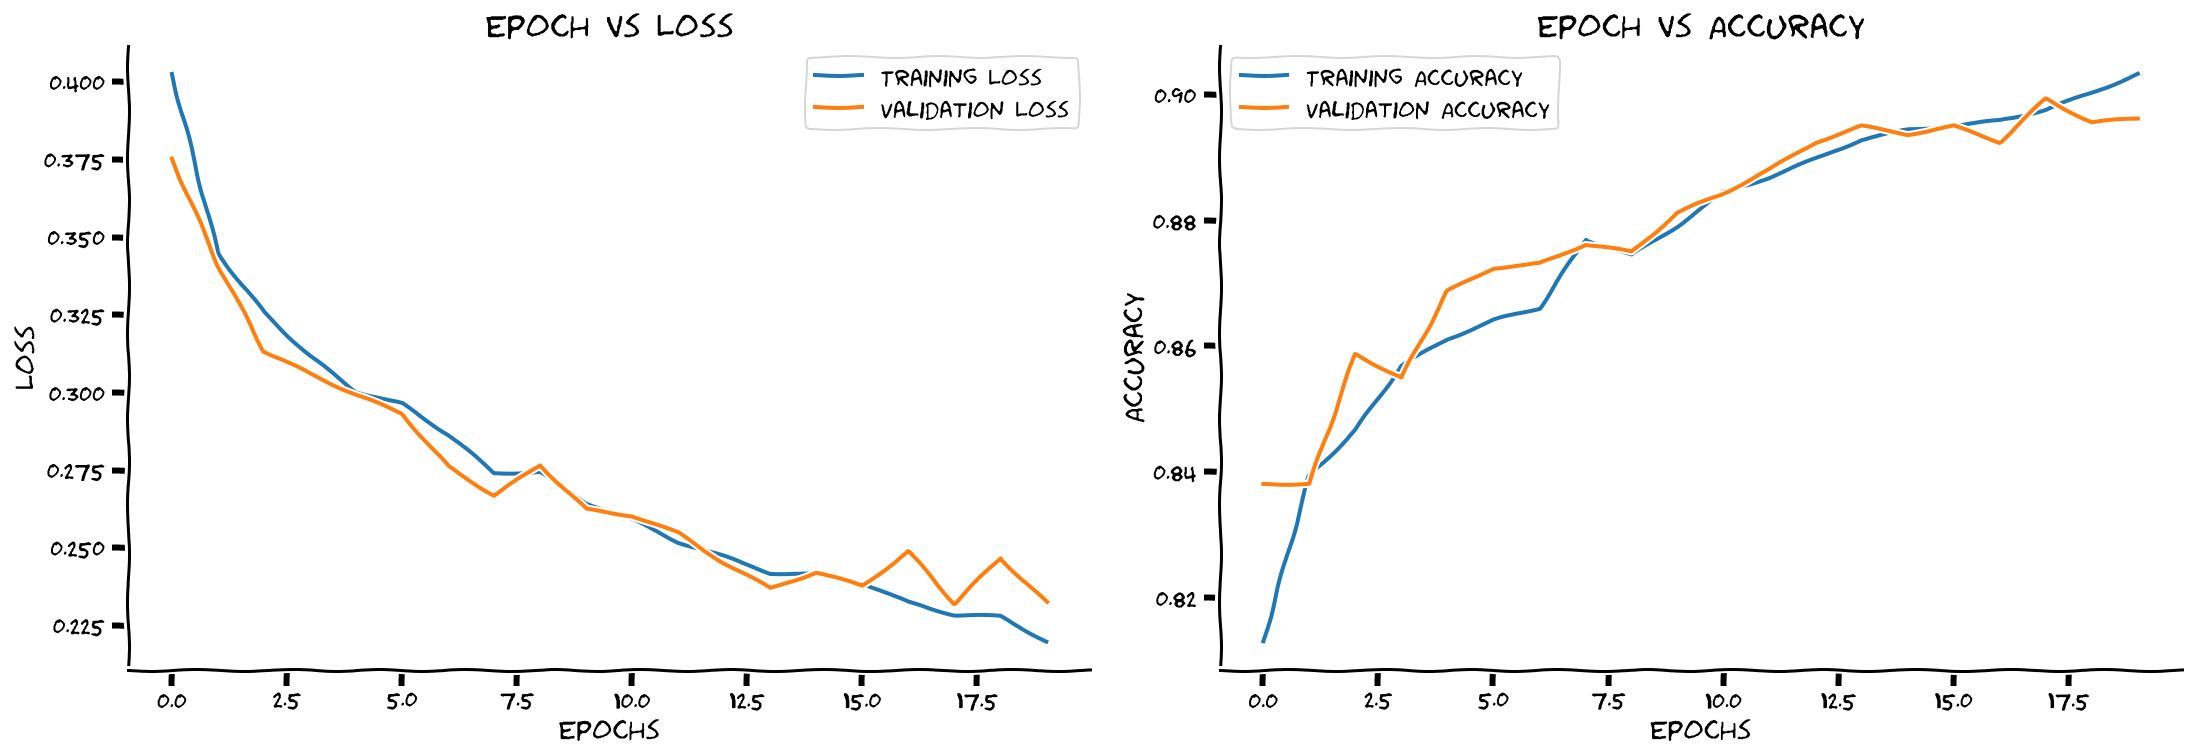

In [31]:
# to_remove solution
def get_augmentation_transforms():
  augmentation_transforms = [transforms.RandomRotation(10), transforms.RandomHorizontalFlip()]

  return augmentation_transforms


set_seed(SEED)
net3 = FMNIST_Net2().to(DEVICE)  # get the network

## Uncomment below to test your function
train_loader, validation_loader, test_loader = transforms_custom(SEED)
train_loss, train_acc, validation_loss, validation_acc = train(net3, DEVICE, train_loader, validation_loader, 20)
with plt.xkcd():
  plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

Run the next cell to get the accuracy on the data!

In [32]:
test(net3, DEVICE, test_loader)

'88.25%'

## Think! 3.1: Data Augmentation

Did the training accuracy reduce further compared to with dropout alone? Is the model still overfitting?

In [33]:
# to_remove explanation

"""
The model does not overfit anymore as both training and validation loss decrease
during training.
""";

Great! In this section you trained what may have been your very first CNN. You added regularization and data augmentation in order to get a model that generalizes well. All the pieces are beginning to fit together!

Next we will talk about RNNs, which parameter share over time.